#Can we use a single SAE across multiple layers of a transformer, to get comparable feature activations axcross layers (aka interpretability)?

##Background

*SAEs* can be used to interpret a part of the residual stream in a transformer

*Activations* are temporary numbers calculated during a formward pass, and are functions of the input

We can use *hooks* to access a the activation values during a forward pass

##Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/LLM work/InterpViz')

## Install packages, import & set parameters

In [ ]:
%pip install transformer_lens
#%pip install circuitsvis
# Install a faster Node version
#!curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

In [4]:
%pip install sae-lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pip install datasets

In [5]:
#from arena notes
import torch as t
import sys
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import List, Optional, Tuple
import functools #from functools import partial
from transformer_lens.hook_points import HookPoint

In [6]:
#from Dan
from transformer_lens import HookedTransformer, utils #, HookedTransformerConfig, FactoredMatrix, ActivationCache
from huggingface_hub import hf_hub_download
from sae_lens import LanguageModelSAERunnerConfig, SparseAutoencoder
from sae_lens.training.utils import BackwardsCompatibleUnpickler
from types import SimpleNamespace

import pickle
import torch

In [ ]:
# from Neel's demo notebook - on top of the above
#from fancy_einsum import einsum
#import tqdm.auto as tqdm

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
torch.set_grad_enabled(False)

MAIN = __name__ = "__main__"

##Loading LLM:
`HookedTransformer.from_pretrained(MODEL_NAME)`

In [9]:
if MAIN:
  #device = t.device("cuda" t.cuda.is_available() else "cpu")
  device = utils.get_device()

In [10]:
device

device(type='cuda')

f(activations_in, activations_out) --> R_n (scalar number)

In [ ]:
##tokenising example
#text = "Let's test if this thing works"
#gpt2_small = HookedTransformer.from_pretrained("gpt2-small", device=device)
#gpt2_small.to_str_tokens(text)

['<|endoftext|>', 'Let', "'s", ' test', ' if', ' this', ' thing', ' works']

FROM DAN:

In [11]:
MODEL_NAME = "gpt2-small"
REPO_ID = "jbloom/GPT2-Small-SAEs"

def load_model():
    return HookedTransformer.from_pretrained(MODEL_NAME) #by default do not prepend the BOS token to the string
    #default_prepend_bos=False

def load_sae(layer):
    ''' Load the SAE trained for a particular layer of the model
    NOTE this is currently configured only for gpt2-small, not other models'''
    filename = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"
    path = hf_hub_download(repo_id=REPO_ID, filename=filename)
    # Hacky way to get torch to unpickle an old version of SAELens model
    fake_pickle = SimpleNamespace()
    fake_pickle.Unpickler = BackwardsCompatibleUnpickler
    fake_pickle.__name__ = pickle.__name__
    data = torch.load(path, map_location=torch.device("cpu"), pickle_module=fake_pickle)
    sparse_autoencoder = SparseAutoencoder(cfg=data["cfg"])
    sparse_autoencoder.load_state_dict(data["state_dict"])
    return sparse_autoencoder

## Testing model load & getting activations out

In [ ]:
test_sae = load_sae(0) #load example sae for first layer
test_sae

(…)2-small_blocks.0.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

SparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
)

Q: is hook_hidden_pre the right HookPoint to use here?

In [ ]:
test_sae.cfg#.hook_point

LanguageModelSAERunnerConfig(model_name='gpt2-small', hook_point='blocks.0.hook_resid_pre', hook_point_layer=0, hook_point_head_index=None, dataset_path='Skylion007/openwebtext', is_dataset_tokenized=False, context_size=128, use_cached_activations=False, cached_activations_path='activations/Skylion007_openwebtext/gpt2-small/blocks.0.hook_resid_pre', d_in=768, n_batches_in_buffer=128, total_training_tokens=300000000, store_batch_size=32, train_batch_size=4096, device=device(type='cuda'), seed=42, dtype=torch.float32, prepend_bos=True, b_dec_init_method='geometric_median', expansion_factor=32, from_pretrained_path=None, d_sae=24576, l1_coefficient=8e-05, lp_norm=1, lr=0.0004, lr_scheduler_name=None, lr_warm_up_steps=5000, lr_end=None, lr_decay_steps=0, n_restart_cycles=1, use_ghost_grads=True, feature_sampling_window=1000, dead_feature_window=5000, dead_feature_threshold=1e-08, log_to_wandb=True, wandb_project='mats_sae_training_gpt2_small_resid_pre_5', run_name='24576-L1-8e-05-LR-0.0004

In [ ]:
logits, cache = model.run_with_cache(prompt)

In [ ]:
prompt

'I am a human'

In [ ]:
logits.shape #torch.Size([1, 5, 50257])
logits

tensor([[[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934],
         [ 6.1485,  6.1941,  3.4867,  ..., -2.5246,  4.2616,  4.7911],
         [ 5.8987,  4.7444,  1.8688,  ..., -2.7672, -0.8520,  3.8448],
         [ 2.9169,  3.3518,  0.9681,  ..., -5.1191, -2.9658,  3.1158],
         [10.4405,  7.1760,  2.8296,  ..., -1.4061, -0.9584,  7.4375]]],
       device='cuda:0')

In [ ]:
#len(cache) #208
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

In [ ]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [ ]:
test_model_activations = cache[test_sae.cfg.hook_point]

In [ ]:
test_model_activations[0][0][0:10]

tensor([ 0.0383, -0.2193,  0.0597, -0.0251,  0.0079, -0.0667, -0.1814, -0.2497,
        -0.1147, -0.0715], device='cuda:0')

In [ ]:
test_sae(test_model_activations)

ForwardOutput(sae_out=tensor([[[ 0.0379, -0.2184,  0.0581,  ..., -0.0318,  0.1889,  0.1799],
         [ 0.1713, -0.1437,  0.0470,  ...,  0.1338, -0.0510, -0.1139],
         [ 0.1635, -0.2057,  0.1663,  ...,  0.2735,  0.0405, -0.0080],
         [-0.0467, -0.0621,  0.1522,  ...,  0.0531,  0.0915, -0.0438],
         [ 0.0237, -0.0306,  0.1471,  ...,  0.3026, -0.1395,  0.0878]]],
       device='cuda:0'), feature_acts=tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), loss=tensor([14.6267, 14.6267, 14.6267,  ..., 14.6267, 14.6267, 14.6267],
       device='cuda:0'), mse_loss=tensor(14.6267, device='cuda:0'), l1_loss=tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'), ghost_grad_loss=tensor(0., device='cuda:0'))

In [ ]:
test_sae(test_model_activations)[:2]

(tensor([[[ 0.0379, -0.2184,  0.0581,  ..., -0.0318,  0.1889,  0.1799],
          [ 0.1713, -0.1437,  0.0470,  ...,  0.1338, -0.0510, -0.1139],
          [ 0.1635, -0.2057,  0.1663,  ...,  0.2735,  0.0405, -0.0080],
          [-0.0467, -0.0621,  0.1522,  ...,  0.0531,  0.0915, -0.0438],
          [ 0.0237, -0.0306,  0.1471,  ...,  0.3026, -0.1395,  0.0878]]],
        device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))

In [ ]:
len(test_sae(test_model_activations))

6

In [ ]:
test_sae(test_model_activations)[0] #this is under the sae_out key in ForwardOutput

tensor([[[ 0.0379, -0.2184,  0.0581,  ..., -0.0318,  0.1889,  0.1799],
         [ 0.1713, -0.1437,  0.0470,  ...,  0.1338, -0.0510, -0.1139],
         [ 0.1635, -0.2057,  0.1663,  ...,  0.2735,  0.0405, -0.0080],
         [-0.0467, -0.0621,  0.1522,  ...,  0.0531,  0.0915, -0.0438],
         [ 0.0237, -0.0306,  0.1471,  ...,  0.3026, -0.1395,  0.0878]]],
       device='cuda:0')

In [ ]:
sae_out, sae_acts = test_sae(test_model_activations)[:2]

Q: how do we interpret sae_out vs sae_acts? We don't seem to be using sae_out later on...

In [ ]:
sae_out

tensor([[[ 0.0379, -0.2184,  0.0581,  ..., -0.0318,  0.1889,  0.1799],
         [ 0.1713, -0.1437,  0.0470,  ...,  0.1338, -0.0510, -0.1139],
         [ 0.1635, -0.2057,  0.1663,  ...,  0.2735,  0.0405, -0.0080],
         [-0.0467, -0.0621,  0.1522,  ...,  0.0531,  0.0915, -0.0438],
         [ 0.0237, -0.0306,  0.1471,  ...,  0.3026, -0.1395,  0.0878]]],
       device='cuda:0')

In [ ]:
sae_acts

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [ ]:
# Data format:

# tokens: list[str]
# layer_vals: list[list[tuple(int, float)]]. Indexed by token id, layer id. Contains: tuple(feature_idx, feature value)

# Function to get SAE activations for all layers

import functools

n_layers = 12
activations = {}

@functools.lru_cache(1)
def get_sae_activations_for_prompt(prompt: str, model: HookedTransformer) -> dict[int, torch.Tensor]:
    # log activations at every layer
    logits, cache = model.run_with_cache(prompt)
    sae_activations = {}

    for layer in range(n_layers):
        sae = load_sae(layer)
        model_activations = cache[sae.cfg.hook_point]
        sae_out, sae_acts = sae(model_activations)[:2]
        sae_activations[layer] = sae_acts

    return sae_activations

In [ ]:
model = load_model()

KeyboardInterrupt: 

In [ ]:
sae_activations = get_sae_activations_for_prompt("Hello world", model)
print(sae_activations[0])

In [ ]:
sae_activations

In [ ]:
sae_activations.items()

In [ ]:
len(sae_activations[0][0][0]) #shape (1,3,24575)

In [ ]:
def export_sae_activations_as_json(prompt):
    token_strs = model.to_str_tokens(prompt, prepend_bos=False)
    print("Token strs: ", token_strs)
    print(len(token_strs))
    sae_activations = get_sae_activations_for_prompt(prompt, model)

    n_tokens = len(token_strs)
    n_layers = len(sae_activations)
    k_features = 10
    # n_features = sae_activations[0].shape[-1]

    layer_vals = [[list() for k in range(n_layers)] for k in range(n_tokens)]

    for layer_idx, sae_acts in sae_activations.items():
        assert len(sae_acts.shape) == 3
        sae_acts = sae_acts[0]
        acts_sorted, indices_sorted = torch.sort(sae_acts, descending=True, dim=-1)
        for token_idx in range(n_tokens):
            token_str = token_strs[token_idx]
            k_acts = acts_sorted[token_idx, :k_features].detach().cpu().numpy()
            k_indices = indices_sorted[token_idx, :k_features].detach().cpu().numpy()
            for feature_idx, feature_value in zip(k_indices, k_acts):
                layer_vals[token_idx][layer_idx].append((str(feature_idx), str(feature_value)))
    return {
        "tokens": token_strs,
        "layer_vals": layer_vals
    }

In [ ]:
prompt = "I am a human"
acts_json = export_sae_activations_as_json(prompt)
print(acts_json)

In [ ]:
import json
with open("acts.json", "w") as file:
    json.dump(acts_json, file)

In [ ]:
logits, cache = model.run_with_cache(prompt)

In [ ]:
cache

In [ ]:
#cache has dimensions [head_index, destination_position, source_position]

In [ ]:
cache['blocks.0.hook_resid_pre']

FROM JOSEPH:

Run with cache - testing:

## Main experiments to evaluate SAE generalisation:

In [27]:
model = load_model()

Loaded pretrained model gpt2-small into HookedTransformer


### Part 1 - testing on one example

In [ ]:
#gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)
#we already have logits, cache from above

In [ ]:
n_layers = 12

layer = 1

sae_i = load_sae(layer)
#logits, cache = model.run_with_cache(prompt)

activation_in = cache[sae_i.cfg.hook_point] #in the for loop this will be each of the available SAEs instead of just the same sae_i
#activation_out = sae_i(activation_in).activation_out
#L2(activations_in, activations_out) #L2 loss

In [ ]:
activation_in #shape torch.Size([1, 5, 768])


tensor([[[ 0.3091,  0.0722,  0.5184,  ...,  1.6378,  1.6544,  0.3109],
         [-0.9422, -0.0742,  0.1968,  ..., -0.4530,  0.3180,  0.3553],
         [-0.9956, -2.5127, -1.5304,  ...,  1.3737,  0.7308,  0.5610],
         [-1.1106,  0.5499,  0.2093,  ..., -0.1486, -0.0052, -0.0160],
         [-0.2372, -0.3673, -1.4040,  ...,  1.3368, -0.8783,  0.3210]]],
       device='cuda:0')

In [ ]:
sae_i(activation_in)

ForwardOutput(sae_out=tensor([[[ 0.0379, -0.2184,  0.0581,  ..., -0.0318,  0.1889,  0.1799],
         [ 0.1713, -0.1437,  0.0470,  ...,  0.1338, -0.0510, -0.1139],
         [ 0.1635, -0.2057,  0.1663,  ...,  0.2735,  0.0405, -0.0080],
         [-0.0467, -0.0621,  0.1522,  ...,  0.0531,  0.0915, -0.0438],
         [ 0.0237, -0.0306,  0.1471,  ...,  0.3026, -0.1395,  0.0878]]],
       device='cuda:0'), feature_acts=tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'), loss=tensor([14.6267, 14.6267, 14.6267,  ..., 14.6267, 14.6267, 14.6267],
       device='cuda:0'), mse_loss=tensor(14.6267, device='cuda:0'), l1_loss=tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0'), ghost_grad_loss=tensor(0., device='cuda:0'))

In [ ]:
sae_out, activation_out = sae_i(activation_in)[:2]

In [ ]:
sae_out.shape, activation_out.shape

(torch.Size([1, 5, 768]), torch.Size([1, 5, 24576]))

Q: check that the second object is what we want to use! --> yes

In [ ]:
activation_out

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [ ]:
activation_in, activation_out

(tensor([[[ 0.3091,  0.0722,  0.5184,  ...,  1.6378,  1.6544,  0.3109],
          [-0.9422, -0.0742,  0.1968,  ..., -0.4530,  0.3180,  0.3553],
          [-0.9956, -2.5127, -1.5304,  ...,  1.3737,  0.7308,  0.5610],
          [-1.1106,  0.5499,  0.2093,  ..., -0.1486, -0.0052, -0.0160],
          [-0.2372, -0.3673, -1.4040,  ...,  1.3368, -0.8783,  0.3210]]],
        device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))

In [ ]:
#try with sae_out instead of activation_out
L2 = loss(activation_in, sae_out)

In [ ]:
L2

tensor(0.0334, device='cuda:0')

In [ ]:
prompt = "I am a human"
logits, cache = model.run_with_cache(prompt)

#loop over all possible layers as activation_in, but sticking with this SAE

n_layers = 12
loss = nn.MSELoss()
losses = {}

sae_to_eval = load_sae(1) #SAE to evaluate - keep this fixed

#cache is pre-loaded above

for layer in range(n_layers):
  sae_i = load_sae(layer)

  activation_in = cache[sae_i.cfg.hook_point] #use the layer from this loop
  sae_out, activation_out = sae_to_eval(activation_in)[:2] #use fixed SAE
  L2_layer = loss(activation_in, sae_out) #TO DO check second object is the right thing to use
  losses[layer] = L2_layer.cpu().data.numpy()

In [ ]:
losses

{0: array(1.9250832, dtype=float32),
 1: array(0.03335358, dtype=float32),
 2: array(9239072., dtype=float32),
 3: array(1.1198591e+08, dtype=float32),
 4: array(1.3316423e+08, dtype=float32),
 5: array(1.4829253e+08, dtype=float32),
 6: array(1.5504456e+08, dtype=float32),
 7: array(1.5973526e+08, dtype=float32),
 8: array(1.6325598e+08, dtype=float32),
 9: array(1.6726038e+08, dtype=float32),
 10: array(1.705063e+08, dtype=float32),
 11: array(1.7832906e+08, dtype=float32)}

In [ ]:

df = pd.DataFrame(index=range(12),columns=range(12))

In [ ]:
df[1] = losses #fill first column of df - for evaluations of the SAE trained on layer 1

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,1.9250832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.03335358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,9239072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,111985910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,133164230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,148292530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,155044560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,159735260.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,163255980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,167260380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Part 2. Now run this in a looop for all SAEs and all layers:

In [ ]:
prompt = "I am a human"
logits, cache = model.run_with_cache(prompt)

#loop over all possible layers as activation_in, but sticking with this SAE
n_layers = 12
loss = nn.MSELoss()
df = pd.DataFrame(index=range(12),columns=range(12))
#cache is pre-loaded above

for layer_to_eval in range(n_layers):
  print(f'evaluating layer {layer_to_eval}')
  losses_layer = {}

  sae_to_eval = load_sae(layer_to_eval) #SAE to evaluate

  for layer in range(n_layers):
    sae_i = load_sae(layer)

    activation_in = cache[sae_i.cfg.hook_point] #use the layer from this loop
    sae_out, activation_out = sae_to_eval(activation_in)[:2] #use fixed SAE
    L2_layer = loss(activation_in, sae_out) #TO DO check second object is the right thing to use
    losses_layer[layer] = L2_layer.cpu().data.numpy()

  print(f'losses for layer {layer_to_eval}: {losses_layer}')
  df[layer_to_eval] = losses_layer

evaluating layer 0
losses for layer 0: {0: array(1.4626651e-05, dtype=float32), 1: array(223168.62, dtype=float32), 2: array(2460829.5, dtype=float32), 3: array(31957394., dtype=float32), 4: array(37169356., dtype=float32), 5: array(41062680., dtype=float32), 6: array(43181700., dtype=float32), 7: array(44557556., dtype=float32), 8: array(45580916., dtype=float32), 9: array(46601816., dtype=float32), 10: array(47479912., dtype=float32), 11: array(49136960., dtype=float32)}
evaluating layer 1
losses for layer 1: {0: array(1.9250832, dtype=float32), 1: array(0.03335358, dtype=float32), 2: array(9239072., dtype=float32), 3: array(1.1198591e+08, dtype=float32), 4: array(1.3316423e+08, dtype=float32), 5: array(1.4829253e+08, dtype=float32), 6: array(1.5504456e+08, dtype=float32), 7: array(1.5973526e+08, dtype=float32), 8: array(1.6325598e+08, dtype=float32), 9: array(1.6726038e+08, dtype=float32), 10: array(1.705063e+08, dtype=float32), 11: array(1.7832906e+08, dtype=float32)}
evaluating la

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.4626651e-05,1.9250832,56.930553,843.00714,652.8216,1283.6748,1441.9731,2029.6222,2069.8713,3124.2344,6245.0566,54385.98
1,223168.62,0.03335358,14.785077,2845.9182,3678.7612,5587.873,2929.5276,1982.3838,8662.78,11757.947,9259.486,92737.17
2,2460829.5,9239072.0,0.050830282,40708.23,72473.94,84473.82,33327.406,21963.168,107589.77,174936.06,142913.11,1666232.9
3,31957394.0,111985910.0,4845680.5,0.1377474,0.45856696,0.6732383,1.255595,1.9762704,2.8333313,4.001411,9.185718,308.15912
4,37169356.0,133164230.0,5688811.0,0.5305742,0.18761443,0.4586115,1.2481996,2.282971,3.2829404,4.7858424,11.7126,355.44052
5,41062680.0,148292530.0,6481958.5,1.7476599,0.51268363,0.22617678,0.815918,1.7559984,2.8047798,4.157694,11.08959,183.32733
6,43181700.0,155044560.0,7080269.0,19.508778,2.642065,1.0342791,0.2860194,0.79751277,1.7323439,3.128359,8.77606,66.32207
7,44557556.0,159735260.0,7419974.5,396.52612,19.772673,4.5912237,0.71612585,0.350563,1.0200665,2.4588976,7.8434176,22.45405
8,45580916.0,163255980.0,7585956.0,3150.306,255.91779,21.020515,3.2217321,1.4406422,0.42514136,1.4644995,6.5690284,9.931599
9,46601816.0,167260380.0,7681056.5,12720.572,2121.0835,182.61195,28.440248,13.167788,1.8636051,0.6079564,5.428064,5.1184554


In [ ]:
df.to_csv('df_12layers.csv')

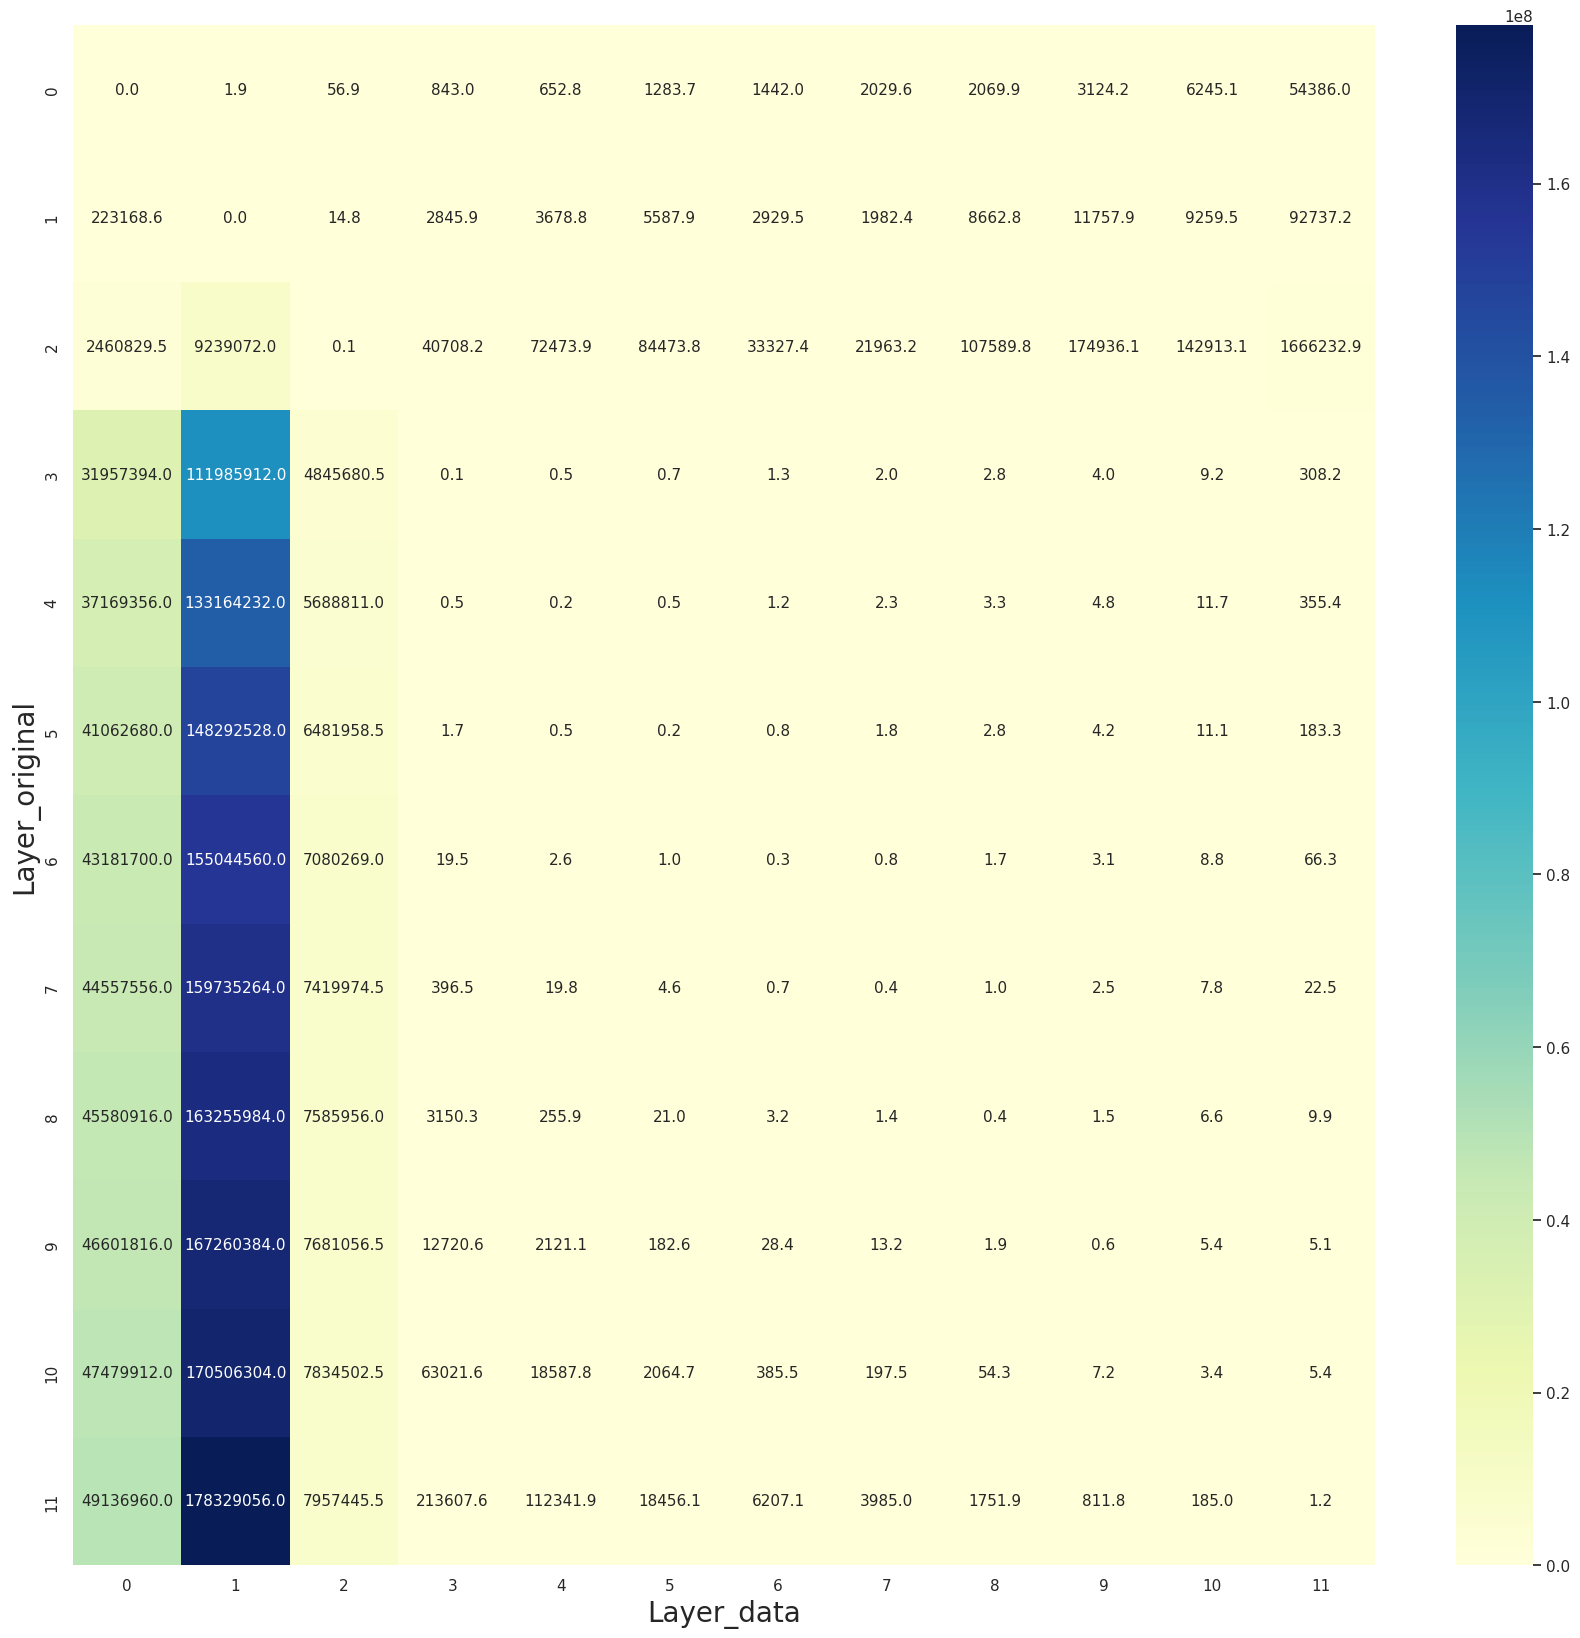

In [ ]:

sns.set_theme(rc={'figure.figsize':(21,20)})

ax = sns.heatmap(df.astype(float), cmap="YlGnBu", annot=True,annot_kws={"fontsize":11}, fmt="0.1f")
plt.xlabel('Layer_SAE_trained_on', fontsize=20)
plt.ylabel('Layer_original', fontsize=20)
plt.title('How well do SAEs trained on each layer perform on each other layer of the model?')

plt.savefig("heatmap_SAE_generalisation.pdf")

Improvements to the analysis to make now:


*   Batch tokens
*   Exclude BOS tag from tokens
*   Smaller figure
*   Scientific notation
*   % Variance explained?
*   Non-divergent color palette
*   pandas df styling - try diff color per column vs per row


Q: does it make sense to consider the first and last layers? --> yes

Q: do huge loss values here make sense? --> yes

In [ ]:
model = load_model()

Loaded pretrained model gpt2-small into HookedTransformer


##--> Remove BOS token:

In [ ]:
prompt = "I am a human"

tokens = model.to_tokens(prompt)

#BOS token is encoded as 50256 in GPT2
#prepend_bos=True
#default_prepend_bos=False whe n instantiating the model

In [ ]:
tokens

tensor([[50256,    40,   716,   257,  1692]], device='cuda:0')

Yes the tokenised version of the text does contain the BOS token!

In [ ]:
logits, cache = model.run_with_cache(tokens[1:])

In [ ]:
n_layers = 1
loss = nn.MSELoss()
df = pd.DataFrame(index=range(12),columns=range(12))
#cache is pre-loaded above

for layer_to_eval in range(n_layers):
  print(f'evaluating layer {layer_to_eval}')
  losses_layer = {}

  sae_to_eval = load_sae(layer_to_eval) #SAE to evaluate

  for layer in range(n_layers):
    sae_i = load_sae(layer)

    activation_in = cache[sae_i.cfg.hook_point]
    sae_out, activation_out = sae_to_eval(activation_in)[:2]
    L2_layer = loss(activation_in, sae_out)
    losses_layer[layer] = L2_layer.cpu().data.numpy()

  print(f'losses for layer {layer_to_eval}: {losses_layer}')
  df[layer_to_eval] = losses_layer

## --> Apply the analysis to a batch of text:

In [31]:
from datasets import load_dataset

#load first 1000 prompts for batch
#data = load_dataset("Skylion007/openwebtext", split="train[:1000]")

In [32]:
data = load_dataset("Abirate/english_quotes")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#data.save_to_disk("data.hf")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
from datasets import load_from_disk
data_reloaded = load_from_disk("data.hf")['text'][0:100]

In [13]:
len(data_reloaded[0])

5516

In [14]:
len(data_reloaded)

100

Go back to working with data, not data_reloaded:

In [40]:
tokens = model.to_tokens(data['train']['quote'])

In [42]:
data['train']['quote'][0]

'“Be yourself; everyone else is already taken.”'

In [43]:
tokens[10]

tensor([50256,   447,   250,   818,  1115,  2456,   314,   460,  2160,   510,
         2279,   314,  1053,  4499,   546,  1204,    25,   340,  2925,   319,
           13,   447,   251, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [52]:
tokens[0][tokens[0]!=50256]

tensor([ 447,  250, 3856, 3511,   26, 2506, 2073,  318, 1541, 2077,   13,  447,
         251], device='cuda:0')

In [53]:
# remove BOS/EOS tokens
tokens_clean = [prompt[prompt != 50256] for prompt in tokens]

In [54]:
tokens_clean

[tensor([ 447,  250, 3856, 3511,   26, 2506, 2073,  318, 1541, 2077,   13,  447,
          251], device='cuda:0'),
 tensor([  447,   250,    40,  1101, 20363,    11, 33440,   290,   257,  1310,
         31955,    13,   314,   787, 10135,    11,   314,   716,   503,   286,
          1630,   290,   379,  1661,  1327,   284,  5412,    13,   887,   611,
           345,   460,   470,  5412,   502,   379,   616,  5290,    11,   788,
           345,  1654,   355,  5968,   836,   470, 10925,   502,   379,   616,
          1266,    13,   447,   251], device='cuda:0'),
 tensor([  447,   250,  7571,  1243,   389, 15541,    25,   262,  6881,   290,
          1692, 37775,    26,   290,   314,  1101,   407,  1654,   546,   262,
          6881,    13,   447,   251], device='cuda:0'),
 tensor([ 447,  250, 2396,  867, 3835,   11,  523, 1310,  640,   13,  447,  251],
        device='cuda:0'),
 tensor([ 447,  250,   32, 2119, 1231, 3835,  318,  588,  257, 1767, 1231,  257,
         5848,   13,  447,  251

In [55]:
tokens_clean[0]

tensor([ 447,  250, 3856, 3511,   26, 2506, 2073,  318, 1541, 2077,   13,  447,
         251], device='cuda:0')

In [56]:
n_layers = 12
loss = nn.MSELoss()
df = pd.DataFrame(index=range(12),columns=range(12))

In [88]:
#logits, cache = model.run_with_cache(tokens_clean)
logits, cache = model.run_with_cache(data['train']['quote'][0:10])

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.27 GiB. GPU 0 has a total capacity of 14.75 GiB of which 719.06 MiB is free. Process 2271 has 14.04 GiB memory in use. Of the allocated memory 12.25 GiB is allocated by PyTorch, and 1.67 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [60]:

#loop over all possible layers as activation_in, but sticking with this SAE
for layer_to_eval in range(n_layers):
  print(f'evaluating layer {layer_to_eval}')
  losses_layer = {}

  sae_to_eval = load_sae(layer_to_eval) #SAE to evaluate

  for layer in range(n_layers):
    sae_i = load_sae(layer) #to get this layer's activations_in

    activation_in = cache[sae_i.cfg.hook_point] #use the layer from this loop
    sae_out, activation_out = sae_to_eval(activation_in)[:2]
    L2_layer = loss(activation_in, sae_out)
    losses_layer[layer] = L2_layer.cpu().data.numpy()

  print(f'losses for layer {layer_to_eval}: {losses_layer}')
  df[layer_to_eval] = losses_layer

evaluating layer 0


(…)2-small_blocks.0.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.1.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.2.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.3.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.4.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.5.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.6.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.7.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.8.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)2-small_blocks.9.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)-small_blocks.10.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…)-small_blocks.11.hook_resid_pre_24576.pt:   0%|          | 0.00/151M [00:00<?, ?B/s]

losses for layer 0: {0: array(7.909308e-05, dtype=float32), 1: array(118618.48, dtype=float32), 2: array(302449.97, dtype=float32), 3: array(2975856.2, dtype=float32), 4: array(3454910.8, dtype=float32), 5: array(3841413.2, dtype=float32), 6: array(4070860., dtype=float32), 7: array(4246566., dtype=float32), 8: array(4474329.5, dtype=float32), 9: array(4725690., dtype=float32), 10: array(5304744.5, dtype=float32), 11: array(6913250.5, dtype=float32)}
evaluating layer 1
losses for layer 1: {0: array(1.919017, dtype=float32), 1: array(0.13033833, dtype=float32), 2: array(839917.6, dtype=float32), 3: array(10180702., dtype=float32), 4: array(12106639., dtype=float32), 5: array(13484481., dtype=float32), 6: array(14111627., dtype=float32), 7: array(14582494., dtype=float32), 8: array(14982934., dtype=float32), 9: array(15585105., dtype=float32), 10: array(16426690., dtype=float32), 11: array(19499638., dtype=float32)}
evaluating layer 2
losses for layer 2: {0: array(68.20378, dtype=float32

Change each batch to contian size 1 (so we are not appending numerous BOS tokens to match the lenght of the longest quote) --> average loss after

In [106]:
losses_layers_allprompts = {key:[] for key in range(n_layers)}

i=0
for prompt in data['train']['quote'][0:10]:
  i += 1
  print(f'processing prompt {i}')
  logits, cache = model.run_with_cache(prompt)

  #loop over all possible layers as activation_in, but sticking with this SAE
  for layer_to_eval in range(n_layers):
    print(f'   evaluating layer {layer_to_eval}')
    losses_layer = {}

    sae_to_eval = load_sae(layer_to_eval) #SAE to evaluate

    for layer in range(n_layers):
      sae_i = load_sae(layer) #to get this layer's activations_in

      activation_in = cache[sae_i.cfg.hook_point] #use the layer from this loop
      sae_out, activation_out = sae_to_eval(activation_in)[:2]
      L2_layer = loss(activation_in, sae_out)
      losses_layer[layer] = L2_layer.cpu().data.numpy()

    #print(f'losses for layer {layer_to_eval}: {losses_layer}')

    losses_layers_allprompts[layer_to_eval].append(losses_layer)

evaluating layer 0
losses for layer 0: {0: array(2.5408759e-05, dtype=float32), 1: array(126296.5, dtype=float32), 2: array(921720.75, dtype=float32), 3: array(11467999., dtype=float32), 4: array(13342287., dtype=float32), 5: array(14749815., dtype=float32), 6: array(15529093., dtype=float32), 7: array(16058609., dtype=float32), 8: array(16482551., dtype=float32), 9: array(16947224., dtype=float32), 10: array(17533426., dtype=float32), 11: array(18950476., dtype=float32)}
evaluating layer 1
losses for layer 1: {0: array(1.9375427, dtype=float32), 1: array(0.03651219, dtype=float32), 2: array(3299669.8, dtype=float32), 3: array(39995056., dtype=float32), 4: array(47560556., dtype=float32), 5: array(52967588., dtype=float32), 6: array(55392600., dtype=float32), 7: array(57125056., dtype=float32), 8: array(58388528., dtype=float32), 9: array(60082988., dtype=float32), 10: array(61675424., dtype=float32), 11: array(67340376., dtype=float32)}
evaluating layer 2
losses for layer 2: {0: array

In [107]:
losses_layers_allprompts

{0: [{0: array(2.5408759e-05, dtype=float32),
   1: array(126296.5, dtype=float32),
   2: array(921720.75, dtype=float32),
   3: array(11467999., dtype=float32),
   4: array(13342287., dtype=float32),
   5: array(14749815., dtype=float32),
   6: array(15529093., dtype=float32),
   7: array(16058609., dtype=float32),
   8: array(16482551., dtype=float32),
   9: array(16947224., dtype=float32),
   10: array(17533426., dtype=float32),
   11: array(18950476., dtype=float32)},
  {0: array(0.00024306, dtype=float32),
   1: array(62411.016, dtype=float32),
   2: array(272016.62, dtype=float32),
   3: array(2969128.2, dtype=float32),
   4: array(3453857.2, dtype=float32),
   5: array(3831873.5, dtype=float32),
   6: array(4071679.8, dtype=float32),
   7: array(4253277.5, dtype=float32),
   8: array(4466200.5, dtype=float32),
   9: array(4772936., dtype=float32),
   10: array(5288656.5, dtype=float32),
   11: array(6814893.5, dtype=float32)},
  {0: array(0.00022663, dtype=float32),
   1: array(

In [108]:
#try example layer
losses_layers_allprompts[0]#.mean()

[{0: array(2.5408759e-05, dtype=float32),
  1: array(126296.5, dtype=float32),
  2: array(921720.75, dtype=float32),
  3: array(11467999., dtype=float32),
  4: array(13342287., dtype=float32),
  5: array(14749815., dtype=float32),
  6: array(15529093., dtype=float32),
  7: array(16058609., dtype=float32),
  8: array(16482551., dtype=float32),
  9: array(16947224., dtype=float32),
  10: array(17533426., dtype=float32),
  11: array(18950476., dtype=float32)},
 {0: array(0.00024306, dtype=float32),
  1: array(62411.016, dtype=float32),
  2: array(272016.62, dtype=float32),
  3: array(2969128.2, dtype=float32),
  4: array(3453857.2, dtype=float32),
  5: array(3831873.5, dtype=float32),
  6: array(4071679.8, dtype=float32),
  7: array(4253277.5, dtype=float32),
  8: array(4466200.5, dtype=float32),
  9: array(4772936., dtype=float32),
  10: array(5288656.5, dtype=float32),
  11: array(6814893.5, dtype=float32)},
 {0: array(0.00022663, dtype=float32),
  1: array(82645.4, dtype=float32),
  2:

In [123]:
pd.DataFrame(losses_layers_allprompts[0][0], index=range(n_layers), columns=range(12))

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
1,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
2,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
3,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
4,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
5,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
6,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
7,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
8,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0
9,0.000025,126296.5,921720.75,11467999.0,13342287.0,14749815.0,15529093.0,16058609.0,16482551.0,16947224.0,17533426.0,18950476.0


In [131]:
for layer in range(n_layers):

  temp_df = pd.DataFrame(losses_layers_allprompts[0][0], index=range(1), columns=range(12))

  for i in range(len(losses_layers_allprompts[0][1:])): #skip the first one as it is initialised above
    #for all values we have for the first SAE
    temp_df = (temp_df + pd.DataFrame(losses_layers_allprompts[0][i], index=range(n_layers), columns=range(12)) ) / 2



In [ ]:
df_new = pd.DataFrame(index=)

In [133]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,7.909308e-05,1.919017,68.20378,988.911,718.9636,1376.0162,1515.2543,2137.245,2182.3892,3307.773,6672.3306,58530.89
1,118618.48,0.13033833,1.6990838,259.35486,335.16916,508.8363,267.38443,181.54814,789.3671,1071.3258,844.30743,9353.971
2,302449.97,839917.6,0.16291691,3701.1545,6589.1177,7680.3286,3030.9575,1998.2428,9783.189,15906.626,12995.905,151984.7
3,2975856.2,10180702.0,440517.3,0.2829068,0.5625092,0.9311512,1.3612403,1.8804734,2.6567385,3.9288032,5.1210227,464.31787
4,3454910.8,12106639.0,517182.9,1.0628544,0.34183177,0.7243229,1.2167844,1.7801322,2.7411487,4.3276577,5.601807,475.5356
5,3841413.2,13484481.0,589430.25,3.8831363,0.5348206,0.4081398,0.81250775,1.5811704,2.743812,4.1300454,5.899465,264.1107
6,4070860.0,14111627.0,644347.44,56.113846,1.8023745,0.68711203,0.43691146,1.0282325,2.2813363,3.8161683,5.9618134,174.77405
7,4246566.0,14582494.0,676476.25,559.82556,25.67725,2.3738139,0.8408497,0.5643044,1.5458184,3.051969,5.774619,74.76309
8,4474329.5,14982934.0,693043.7,3655.0781,434.98,50.09129,18.44523,3.4247484,0.7220802,1.6502409,4.406865,30.947723
9,4725690.0,15585105.0,709982.1,17045.416,3457.5288,361.94403,142.93234,46.34076,3.1142294,1.0393754,3.2671497,12.7476425


In [132]:
temp_df


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
1,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
2,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
3,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
4,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
5,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
6,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
7,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
8,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0
9,0.000054,88425.367188,558995.25,6818394.5,7937966.0,8784211.0,9271490.0,9619164.0,9936094.0,10326847.0,10947576.0,12546326.0


In [ ]:

for layer_to_eval in range(n_layers):
  df[layer_to_eval] = losses_layers_allprompts[layer_to_eval].mean()


In [ ]:
print('df with averaging losses instead of batch of 10')
df

In [61]:
print('original df from 10 prompts')
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,7.909308e-05,1.919017,68.20378,988.911,718.9636,1376.0162,1515.2543,2137.245,2182.3892,3307.773,6672.3306,58530.89
1,118618.48,0.13033833,1.6990838,259.35486,335.16916,508.8363,267.38443,181.54814,789.3671,1071.3258,844.30743,9353.971
2,302449.97,839917.6,0.16291691,3701.1545,6589.1177,7680.3286,3030.9575,1998.2428,9783.189,15906.626,12995.905,151984.7
3,2975856.2,10180702.0,440517.3,0.2829068,0.5625092,0.9311512,1.3612403,1.8804734,2.6567385,3.9288032,5.1210227,464.31787
4,3454910.8,12106639.0,517182.9,1.0628544,0.34183177,0.7243229,1.2167844,1.7801322,2.7411487,4.3276577,5.601807,475.5356
5,3841413.2,13484481.0,589430.25,3.8831363,0.5348206,0.4081398,0.81250775,1.5811704,2.743812,4.1300454,5.899465,264.1107
6,4070860.0,14111627.0,644347.44,56.113846,1.8023745,0.68711203,0.43691146,1.0282325,2.2813363,3.8161683,5.9618134,174.77405
7,4246566.0,14582494.0,676476.25,559.82556,25.67725,2.3738139,0.8408497,0.5643044,1.5458184,3.051969,5.774619,74.76309
8,4474329.5,14982934.0,693043.7,3655.0781,434.98,50.09129,18.44523,3.4247484,0.7220802,1.6502409,4.406865,30.947723
9,4725690.0,15585105.0,709982.1,17045.416,3457.5288,361.94403,142.93234,46.34076,3.1142294,1.0393754,3.2671497,12.7476425


In [90]:
df_num = df.astype('float').round(2)

In [91]:
df_num

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00,1.92,68.20,988.91,718.96,1376.02,1515.25,2137.25,2182.39,3307.77,6672.33,58530.89
1,118618.48,0.13,1.70,259.35,335.17,508.84,267.38,181.55,789.37,1071.33,844.31,9353.97
2,302449.97,839917.62,0.16,3701.15,6589.12,7680.33,3030.96,1998.24,9783.19,15906.63,12995.91,151984.70
3,2975856.25,10180702.00,440517.31,0.28,0.56,0.93,1.36,1.88,2.66,3.93,5.12,464.32
4,3454910.75,12106639.00,517182.91,1.06,0.34,0.72,1.22,1.78,2.74,4.33,5.60,475.54
5,3841413.25,13484481.00,589430.25,3.88,0.53,0.41,0.81,1.58,2.74,4.13,5.90,264.11
6,4070860.00,14111627.00,644347.44,56.11,1.80,0.69,0.44,1.03,2.28,3.82,5.96,174.77
7,4246566.00,14582494.00,676476.25,559.83,25.68,2.37,0.84,0.56,1.55,3.05,5.77,74.76
8,4474329.50,14982934.00,693043.69,3655.08,434.98,50.09,18.45,3.42,0.72,1.65,4.41,30.95
9,4725690.00,15585105.00,709982.12,17045.42,3457.53,361.94,142.93,46.34,3.11,1.04,3.27,12.75


In [92]:
import seaborn as sns
cm = sns.light_palette("purple", as_cmap=True)

print('\n How well do SAEs trained on each layer perform on each other layer of the model? \n')

print('MSE Loss for a batch of 10 example quote prompts')
df_num.style.background_gradient(cmap=cm)

#df.to_html(table_title="How well do SAEs trained on each layer perform on each other layer of the model?")


 How well do SAEs trained on each layer perform on each other layer of the model? 

MSE Loss for a batch of 10 example quote prompts


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,1.920000,68.200000,988.910000,718.960000,1376.020000,1515.250000,2137.250000,2182.390000,3307.770000,6672.330000,58530.890000
1,118618.480000,0.130000,1.700000,259.350000,335.170000,508.840000,267.380000,181.550000,789.370000,1071.330000,844.310000,9353.970000
2,302449.970000,839917.620000,0.160000,3701.150000,6589.120000,7680.330000,3030.960000,1998.240000,9783.190000,15906.630000,12995.910000,151984.700000
3,2975856.250000,10180702.000000,440517.310000,0.280000,0.560000,0.930000,1.360000,1.880000,2.660000,3.930000,5.120000,464.320000
4,3454910.750000,12106639.000000,517182.910000,1.060000,0.340000,0.720000,1.220000,1.780000,2.740000,4.330000,5.600000,475.540000
5,3841413.250000,13484481.000000,589430.250000,3.880000,0.530000,0.410000,0.810000,1.580000,2.740000,4.130000,5.900000,264.110000
6,4070860.000000,14111627.000000,644347.440000,56.110000,1.800000,0.690000,0.440000,1.030000,2.280000,3.820000,5.960000,174.770000
7,4246566.000000,14582494.000000,676476.250000,559.830000,25.680000,2.370000,0.840000,0.560000,1.550000,3.050000,5.770000,74.760000
8,4474329.500000,14982934.000000,693043.690000,3655.080000,434.980000,50.090000,18.450000,3.420000,0.720000,1.650000,4.410000,30.950000
9,4725690.000000,15585105.000000,709982.120000,17045.420000,3457.530000,361.940000,142.930000,46.340000,3.110000,1.040000,3.270000,12.750000


In [148]:
import seaborn as sns
cm = sns.light_palette("purple", as_cmap=True)

print('\n How well do SAEs trained on each layer perform on each other layer of the model? \n')

print('MSE Loss for a batch of 10 example quote prompts')
df_num.style.format(precision=2).background_gradient(cmap=cm)


 How well do SAEs trained on each layer perform on each other layer of the model? 

MSE Loss for a batch of 10 example quote prompts


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00,1.92,68.20,988.91,718.96,1376.02,1515.25,2137.25,2182.39,3307.77,6672.33,58530.89
1,118618.48,0.13,1.70,259.35,335.17,508.84,267.38,181.55,789.37,1071.33,844.31,9353.97
2,302449.97,839917.62,0.16,3701.15,6589.12,7680.33,3030.96,1998.24,9783.19,15906.63,12995.91,151984.70
3,2975856.25,10180702.00,440517.31,0.28,0.56,0.93,1.36,1.88,2.66,3.93,5.12,464.32
4,3454910.75,12106639.00,517182.91,1.06,0.34,0.72,1.22,1.78,2.74,4.33,5.60,475.54
5,3841413.25,13484481.00,589430.25,3.88,0.53,0.41,0.81,1.58,2.74,4.13,5.90,264.11
6,4070860.00,14111627.00,644347.44,56.11,1.80,0.69,0.44,1.03,2.28,3.82,5.96,174.77
7,4246566.00,14582494.00,676476.25,559.83,25.68,2.37,0.84,0.56,1.55,3.05,5.77,74.76
8,4474329.50,14982934.00,693043.69,3655.08,434.98,50.09,18.45,3.42,0.72,1.65,4.41,30.95
9,4725690.00,15585105.00,709982.12,17045.42,3457.53,361.94,142.93,46.34,3.11,1.04,3.27,12.75


In [ ]:
%pip install dataframe_image

In [141]:
import dataframe_image as dfi

dfi.export(df_num, 'df_styled.png')

OSError: Chrome executable not able to be found on your machine

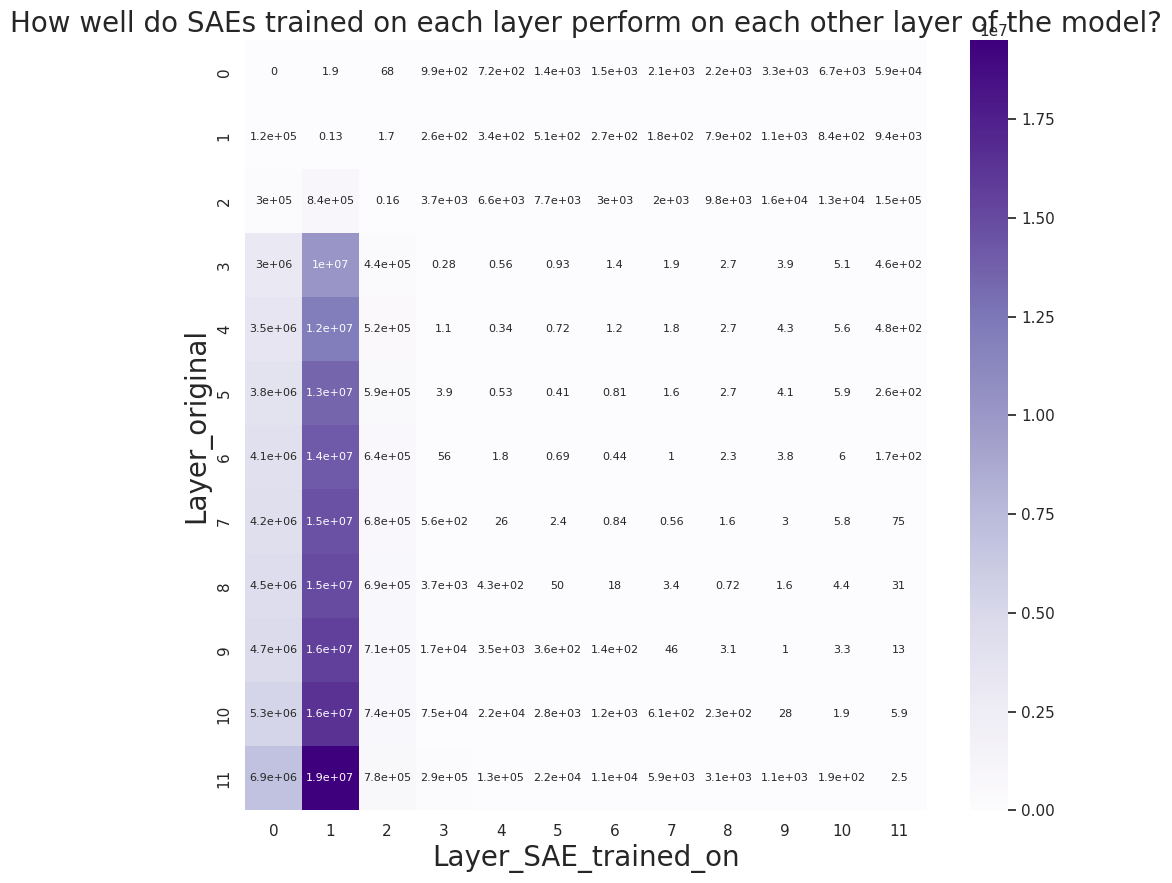

In [99]:

sns.set_theme(rc={'figure.figsize':(11,8)})

ax = sns.heatmap(df_num.astype(float), cmap="Purples", annot=True,annot_kws={"fontsize":8}, fmt=".2g") #fmt="0.1f")
plt.xlabel('Layer_SAE_trained_on', fontsize=20)
plt.ylabel('Layer_original', fontsize=20)
plt.title('How well do SAEs trained on each layer perform on each other layer of the model?', fontsize=20)

plt.savefig("heatmap_SAE_generalisation_batch10quotes.pdf")

Draft for loop (starting point)

In [ ]:
    for layer in range(n_layers):
        sae = load_sae(layer)
        model_activations = cache[sae.cfg.hook_point]
        sae_out, sae_acts = sae(model_activations)[:2]
        sae_activations[layer] = sae_acts

In [ ]:
for _ in range(10):
  batch_tokens = loader.get_batch_tokens()
  logists, cache = model.run_with_cache(batch_tokens)

  for l in layer:
    activation_in = cache("...", l)
    activation_out = sae(activation_in).activation_out
    L2(activations_in, activations_out) #L2 loss

We will be comparing how SAEs trained on a certain layer perform on all other layers of the model

We want this to output a dataframe in the following format :


            Layer_original
    Layer_data  ...


Hypothesis:
--> diagonal is likely to be well-performing; SAEs trained on later layers are likley to be ok performing on earlier tokens; SAEs trained on earlier layers are likely to be badly performing on later layers